In [ ]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
from torch.nn.parameter import Parameter
from torch.utils.data import random_split
from torch.nn import MSELoss, SiLU

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

import numpy as np
import time
# from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io
from Load_data2 import custom_csv_parser
torch.set_default_dtype(torch.float)
torch.manual_seed(1234)
np.random.seed(1234)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda':
    print(torch.cuda.get_device_name())



cpu


In [61]:


# Parameters for equation

def grad(function,var):
    return autograd.grad(function, var, grad_outputs=torch.ones_like(function), create_graph=True)[0]



class PINN(nn.Module):

    def __init__(self,layers,starting_guess):
        super(PINN, self).__init__()

        

        # self.input = nn.Linear(1, 20)
        # self.hidden = nn.Linear(20, 20)
        # self.out = nn.Linear(20, 1)
        
        self.activation = nn.SiLU()
        self._initialize_weights()
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)]) 

        self.tau_1 = torch.tensor([49.0], requires_grad=True, device=device)       # [min]
        self.tau_2 = torch.tensor([47.0], requires_grad=True, device=device)       # [min]
        self.C_I = torch.tensor([20.1], requires_grad=True, device=device)         # [dL/min]
        self.p_2 = torch.tensor([0.0106], requires_grad=True, device=device)       # [min^(-1)]
        self.GEZI = torch.tensor([0.0022], requires_grad=True, device=device)      # [min^(-1)]
        self.EGP_0 = torch.tensor([1.33], requires_grad=True, device=device)       # [(mg/dL)/min]
        self.V_G = torch.tensor([253.0], requires_grad=True, device=device)        # [dL]
        self.tau_m = torch.tensor([47.0], requires_grad=True, device=device)       # [min]
        self.tau_sc = torch.tensor([5.0], requires_grad=True, device=device)       # [min]
        # self.S_I = torch.tensor([0.0081], requires_grad=True, device=device)

        self.S_I = torch.tensor([starting_guess], requires_grad=True).float().to(device)
        self.S_I = nn.Parameter(self.S_I)


        # training

    def forward(self, x):

        # if torch.is_tensor(t) != True:         
        #     t = torch.from_numpy(t)                
        # u = t.float()
   
        # for layer in self.linears:
        #     u = self.activation(layer(u))

        # u = self.output(u)
        # return u

        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        layer = x.float()
        for i in range(len(layers)-2):  
            z = self.linears[i](layer)              
            layer = self.activation(z)

        layer = self.linears[-1](layer)
        return layer

    def _initialize_weights(self):
        # Initialize weights using Xavier initialization and biases to zero
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    # We are using a simple exponential equation to test the PINN

    def LossData(self,t,data,scalar):
        
        X = self.forward(t)

        D1 = X[:,0]
        D2 = X[:,1]
        I_sc = X[:,2]
        I_p = X[:,3]
        I_eff = X[:,4]
        G = X[:,5]
        G_sc = X[:,6]

        D1_data = data["D1"]
        D2_data = data["D2"]
        I_sc_data = data["I_sc"]
        I_p_data = data["I_p"]
        I_eff_data = data["I_eff"]
        G_data = data["G"]
        G_sc_data = data["G_sc"]


        loss_D1 = 1/torch.mean(D1_data) * torch.mean((D1 - D1_data)**2)
        loss_D2 = 1/torch.mean(D2_data) * torch.mean((D2 - D2_data)**2)

        loss_I_sc =1/torch.mean(I_sc_data) * torch.mean((I_sc - I_sc_data)**2)
        loss_I_p = 1/torch.mean(I_p_data) * torch.mean((I_p - I_p_data)**2)
        loss_I_eff = 1/torch.mean(I_eff_data) * torch.mean((I_eff - I_eff_data)**2)

        loss_G = 1/torch.mean(G_data)* torch.mean((G - G_data)**2)
        loss_G_sc = 1/torch.mean(G_sc_data)* torch.mean((G_sc - G_sc_data)**2)

        # You should also scale the loss here so that all the losses have the same weight.
        loss_data = loss_D1 + loss_D2 + loss_I_sc + loss_I_p + loss_I_eff + loss_G + loss_G_sc
        return loss_data

        # X = self.forward(t)

        # D1 = X[:,0]
        # D2 = X[:,1]
        # I_sc = X[:,2]
        # I_p = X[:,3]
        # I_eff = X[:,4]
        # G = X[:,5]
        # G_sc = X[:,6]

        # D1_data = data["D1"]
        # D2_data = data["D2"]
        # I_sc_data = data["I_sc"]
        # I_p_data = data["I_p"]
        # I_eff_data = data["I_eff"]
        # G_data = data["G"]
        # G_sc_data = data["G_sc"]

        


        # loss_D1 = scalar[0] * torch.sum( (D1 - D1_data) **2)
        # loss_D2 = scalar[1] * torch.sum( (D2 - D2_data) **2)

        # loss_I_sc = scalar[2] * torch.sum( (I_sc - I_sc_data) **2)
        # loss_I_p = scalar[3] * torch.sum( (I_p - I_p_data) **2)
        # loss_I_eff = scalar[4] * torch.sum((I_eff - I_eff_data)**2)

        # loss_G = scalar[5] * torch.sum((G - G_data)**2)
        # loss_G_sc = scalar[6] * torch.sum((G_sc - G_sc_data)**2)

        # # You should also scale the loss here so that all the losses have the same weight.
        # loss_data = loss_D1 + loss_D2 + loss_I_sc + loss_I_p + loss_I_eff + loss_G + loss_G_sc
        # return loss_data

    def LossPDE(self,t,data,scalar):

        X = self.forward(t)

        u = data["Insulin"]
        d = data["Meal"]


        D1 = X[:,0]
        D2 = X[:,1]

        I_sc = X[:,2]
        I_p = X[:,3]
        I_eff = X[:,4]

        G = X[:,5]
        G_sc = X[:,6]

        D1_t = grad(D1,t)
        D2_t = grad(D2,t)

        I_sc_t = grad(I_sc,t)
        I_p_t = grad(I_p,t)
        I_eff_t = grad(I_eff,t)

        G_t = grad(G,t)
        G_sc_t = grad(G_sc,t)

        # Parameters
        tau_1 = self.tau_1
        tau_2 = self.tau_2
        C_I = self.C_I
        p_2 = self.p_2
        GEZI = self.GEZI
        EGP_0 = self.EGP_0
        V_G = self.V_G
        tau_m = self.tau_m
        tau_sc = self.tau_sc
        S_I = self.S_I # The special parameter we want to predict.
        ## Define the differential equations

        # Meal equations
        eq_M1 = D1_t - (d - D1/tau_m)
        eq_M2 =  D2_t -  ((D1- D2) /tau_m)

        # Insulin equations
        eq_I1 = I_sc_t - ( u/(tau_1*C_I) - I_sc/tau_1 )
        eq_I2 = I_p_t - ( (I_sc-I_p) /tau_2)
        eq_I3 = I_eff_t - ( -p_2*I_eff + p_2*S_I*I_p )

        # Glucose equations
        eq_G1 = G_t - ( - G * (I_eff + GEZI)  + EGP_0 + 1000*D2/(V_G*tau_m) )
        eq_G2 = G_sc_t - ( (G - G_sc) / tau_sc )

        # Her kan du skalere ligningerne så alle oder har samme vægt. Det tror vi er vigtigt.
        loss_PDE = torch.mean((eq_M1)**2) + torch.mean((eq_M2) **2) + torch.mean((eq_I1)**2) + torch.mean((eq_I2)**2) + torch.mean((eq_I3)**2) + torch.mean((eq_G1)**2) + torch.mean(eq_G2**2)

        return loss_PDE

        # X = self.forward(t)

        # u = data["Insulin"]
        # d = data["Meal"]


        # D1 = X[:,0]
        # D2 = X[:,1]
        # I_sc = X[:,2]
        # I_p = X[:,3]
        # I_eff = X[:,4]

        # G = X[:,5]
        # G_sc = X[:,6]

        # D1_t = grad(D1,t)
        # D2_t = grad(D2,t)

        # I_sc_t = grad(I_sc,t)
        # I_p_t = grad(I_p,t)
        # I_eff_t = grad(I_eff,t)

        # G_t = grad(G,t)
        # G_sc_t = grad(G_sc,t)

        # # Parameters
        # tau_1 = self.tau_1
        # tau_2 = self.tau_2
        # C_I = self.C_I
        # p_2 = self.p_2
        # GEZI = self.GEZI
        # EGP_0 = self.EGP_0
        # V_G = self.V_G
        # tau_m = self.tau_m
        # tau_sc = self.tau_sc
        # # S_I = self.S_I # The special parameter we want to predict.
        # ## Define the differential equations

        # # Meal equations
        # eq_M1 = D1_t - (d - D1/tau_m)
        # eq_M2 =  D2_t -  ((D1- D2) /tau_m)

        # # Insulin equations
        # eq_I1 = I_sc_t - ( u/(tau_1*C_I) - I_sc/tau_1 )
        # eq_I2 = I_p_t - ( (I_sc-I_p) /tau_2)
        # eq_I3 = I_eff_t - ( -p_2*I_eff + p_2*S_I*I_p )

        # # Glucose equations
        # eq_G1 = G_t - ( - G * (I_eff + GEZI)  + EGP_0 + 1000*D2/(V_G*tau_m) )
        # eq_G2 = G_sc_t - ( (G - G_sc) / tau_sc )

        # # Her kan du skalere ligningerne så alle oder har samme vægt. Det tror vi er vigtigt.

        
        # loss_PDE = torch.sum( (scalar[0] * eq_M1)**2)
        # + torch.sum((scalar[1] * eq_M2)**2)
        # + torch.sum((scalar[2] * eq_I1)**2)
        # + torch.sum((scalar[3] * eq_I2)**2)
        # + torch.sum((scalar[4] * eq_I3)**2)
        # + torch.sum((scalar[5] * eq_G1)**2)
        # + torch.sum((scalar[6] * eq_G2)**2)

        # return loss_PDE
        
    def LossComb(self,t,data):
        loss_data = self.LossData(t,data)
        loss_pde = self.LossPDE(t,data)

        # print("bc data type: ",type(loss_bc))
        # print("pde data type: ",type(loss_pde))
        
        return loss_data + loss_pde


if __name__ == "__main__":

    layers = np.array([1,128,128,128,7])
    starting_guess = 0.0

    ## Load data

    data = custom_csv_parser('Patient2.csv')
    n_data = len(data["D1"])

    # split data into validation and trainning

    # t_train, t_val, data_train, data_val = train_test_split(data["t"], data, test_size=0.2, random_state=42)
    torch.manual_seed(42)

    indices = torch.randperm(n_data)

    n_train = int(n_data * 0.1)   # 50% training data

    train_indices = indices[:n_train]
    val_indices = indices[n_train:]

    # Define  
    T = 300


    # Split the data dictionary 
    data_train = {}
    data_val = {}
    scalar = torch.zeros(80,device=device)


    for i,key in enumerate(data.keys()):
        data_tensor = torch.tensor(data[key], device=device,requires_grad=True)          # Ensure data is a tensor
        data_train[key] = data_tensor[train_indices]
        data_val[key] = data_tensor[val_indices]

        scalar[i] = 1/torch.mean(data_tensor[train_indices])

    


    t_train_data = data_train["t"].reshape(-1, 1)
    t_val_data = data_val["t"].reshape(-1, 1)

    PINN = PINN(layers,starting_guess).to(device)

    numb_of_epochs = 20000
    S_I = torch.tensor([0.0], requires_grad=True, device=device)
    optimizer = torch.optim.Adam(PINN.parameters(), lr=1e-3,weight_decay=1e-5)
    # scheduler = StepLR(optimizer, step_size=10000, gamma=0.95)

    # 

    for epoch in range(numb_of_epochs):
        optimizer.zero_grad()
        
        loss_ODE = PINN.LossPDE(t_train_data, data_train,scalar)
        loss_Data = PINN.LossData(t_train_data, data_train,scalar)

        loss = loss_ODE + loss_Data

        loss.backward(retain_graph=True)
        # loss.backward(etain_graph=True)
        optimizer.step()
        # scheduler.step()

        if epoch % 500 == 0:

            with torch.no_grad():
                PINN.eval()
                val_loss = PINN.LossData(t_val_data, data_val,scalar)
                PINN.train()

            print(f"Epoch {epoch}, Trainning Loss: {loss.item():.2f}, Validation Loss: {val_loss.item():.2f} Estimated S_I: {PINN.S_I.item():.6f}, ODE Loss: {loss_ODE:.2f}, Data Loss: {loss_Data:.2f}")






Epoch 0, Trainning Loss: 3072.88, Validation Loss: 10662.50 Estimated S_I: -0.001000, ODE Loss: 1270.25, Data Loss: 1802.64
Epoch 500, Trainning Loss: 229.08, Validation Loss: 181.13 Estimated S_I: 0.008544, ODE Loss: 46.34, Data Loss: 182.75
Epoch 1000, Trainning Loss: 251.62, Validation Loss: 197.58 Estimated S_I: 0.046958, ODE Loss: 52.58, Data Loss: 199.04
Epoch 1500, Trainning Loss: 177.04, Validation Loss: 118.82 Estimated S_I: 0.056088, ODE Loss: 55.18, Data Loss: 121.85
Epoch 2000, Trainning Loss: 171.28, Validation Loss: 126.49 Estimated S_I: -0.016868, ODE Loss: 43.57, Data Loss: 127.72
Epoch 2500, Trainning Loss: 164.84, Validation Loss: 115.98 Estimated S_I: -0.012674, ODE Loss: 46.41, Data Loss: 118.44
Epoch 3000, Trainning Loss: 139.90, Validation Loss: 98.71 Estimated S_I: -0.011659, ODE Loss: 40.10, Data Loss: 99.80
Epoch 3500, Trainning Loss: 9816.58, Validation Loss: 408.62 Estimated S_I: -0.002789, ODE Loss: 9443.94, Data Loss: 372.64
Epoch 4000, Trainning Loss: 302.

KeyboardInterrupt: 

C:\Users\anton\AppData\Local\Temp\ipykernel_18256\3532431176.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print("Error" , torch.sum((torch.tensor(pred[:,i]) - true_val)**2))


Error tensor(1957.1306)


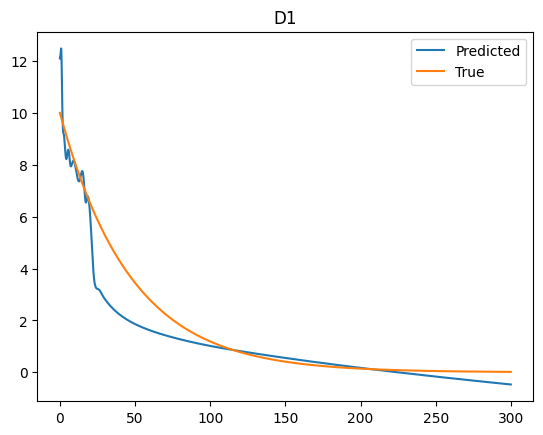

Error tensor(2335.5273)


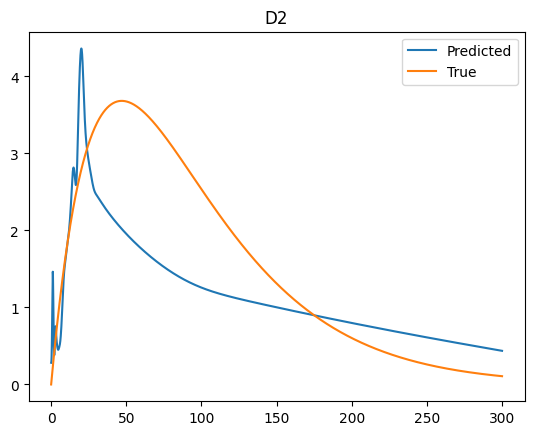

Error tensor(93.0391)


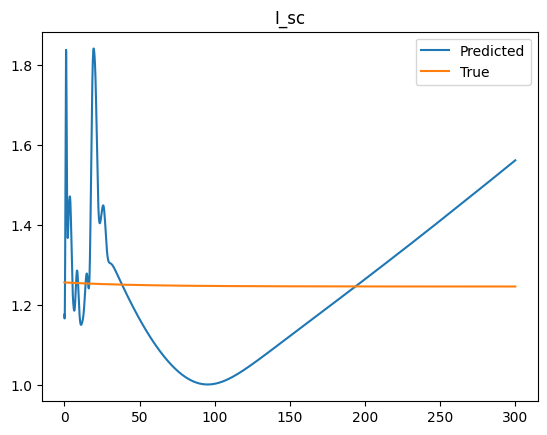

Error tensor(63.4041)


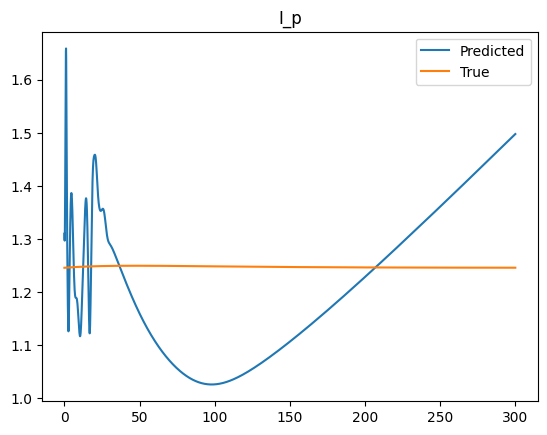

Error tensor(6.9780)


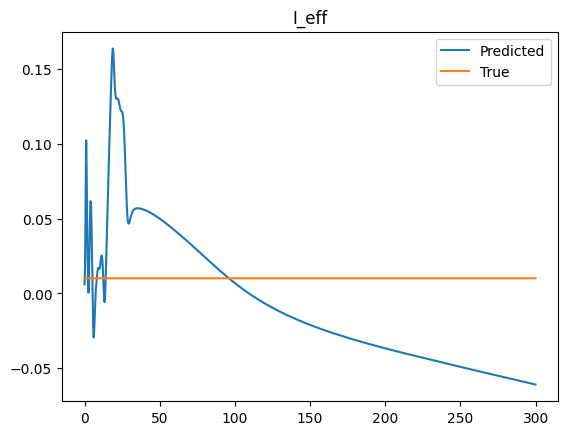

Error tensor(11929234.)


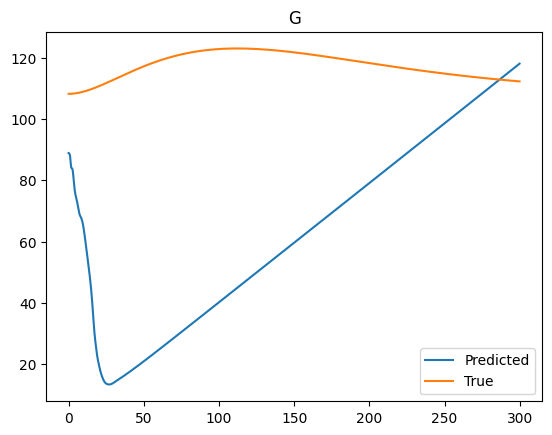

Error tensor(9741450.)


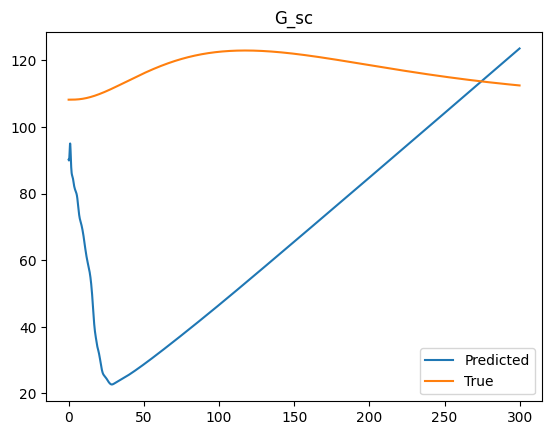

In [62]:
PINN.eval()
t_plot = torch.tensor(data["t"], device=device).reshape(-1, 1)

pred = PINN.forward(t_plot)

pde_keys = ['D1', 'D2', 'I_sc','I_p', 'I_eff', 'G', 'G_sc']
patient_keys = ['tau1', 'tau2', 'Ci', 'p2', 'GEZI', 'EGP0', 'Vg', 'taum', 'tausc']
patient_keys_si = ['tau1', 'tau2', 'Ci', 'p2', 'Si', 'GEZI', 'EGP0', 'Vg', 'taum', 'tausc']

# G_pred = pred[:,5].reshape(-1,1)
# G_true = data_tensor["G"].reshape(-1,1)
# G_true_2 = data_tensor["G_sc"].reshape(-1,1)
ts_test_plot = t_plot.cpu().numpy()


for i,key in enumerate(pde_keys):
    true_val = torch.tensor(data[key], device=device)
    plt.figure()
    plt.plot(ts_test_plot, pred[:,i].detach().cpu().numpy(), label='Predicted')
    plt.plot(ts_test_plot, true_val.cpu().numpy(), label='True')
    print("Error" , torch.sum((torch.tensor(pred[:,i]) - true_val)**2))
    plt.legend()
    plt.title(pde_keys[i])
    plt.show()